ssh -L 51433:fatboy.phys.washington.edu:1433 gateway.astro.washington.edu

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from lsst.sims.catalogs.generation.db import CatalogDBObject
from lsst.sims.catUtils.baseCatalogModels import *
from lsst.sims.catUtils.exampleCatalogDefinitions import *
import numpy as np
from lsst.sims.utils import ObservationMetaData
import lsst.sims.photUtils.Sed as Sed
import lsst.sims.photUtils.Bandpass as Bandpass
from lsst.sims.photUtils import calcMagError_m5, PhotometricParameters

/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/yoachim/lsst/DarwinX86/sims_catalogs_generation/sims_2.2.4/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/yoachim/lsst/DarwinX86/sims_catalogs_generation/sims_2.2.4/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


In [3]:
ra = 0.  # Degrees
dec = 0.  # Degrees
boundLength = 1. 
dbobj = CatalogDBObject.from_objid('allstars')
obs_metadata = ObservationMetaData(boundType='circle',pointingRA=ra,
                                   pointingDec=dec,boundLength=boundLength, mjd=5700)
t = dbobj.getCatalog('ref_catalog_star', obs_metadata=obs_metadata)

In [4]:
constraint = 'rmag < 18 and rmag > 15'
chunks = t.db_obj.query_columns(colnames=['magNorm', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ymag',
                                          'sedfilename', 'ebv', 'especid', 'feh'], 
                                obs_metadata=obs_metadata,constraint=constraint, 
                                chunk_size=1000000)
for chunk in chunks:
    catalog = chunk

/Users/yoachim/lsst/DarwinX86/sqlalchemy/2015_10.0-1-gaf5a1cb/lib/python/SQLAlchemy-1.0.8-py2.7-macosx-10.5-x86_64.egg/sqlalchemy/sql/elements.py:3779: SAWarning: Textual SQL expression 'rmag < 18 and rmag > 15' should be explicitly declared as text('rmag < 18 and rmag > 15') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


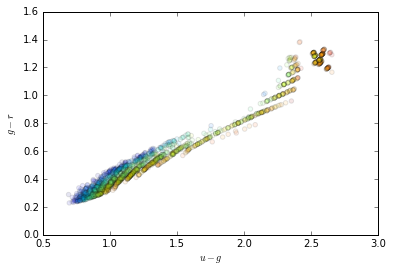

In [13]:
plt.scatter(catalog['umag']-catalog['gmag'], catalog['gmag']-catalog['rmag'], c=catalog['feh'], alpha=0.1)
plt.xlabel(r'$u-g$')
plt.ylabel(r'$g-r$')

Thoughts:

Maybe go though all the stellar spectra and compute the colors for a grid of extinction values.  Then I can grab a star, add noise to the color measures in a Monte Carlo kind of way and then find the nearest model in color-space for each realization.  That gives me a spread of metallicities and extinction values.  

1. make an array that's star: feh, ebv, u-g, g-r, r-i, i-z, z-y. 
2. construct a kdtree for the colors.
3. query a spot in the sky. For each star in the patch compute the colors and expected colors
4. given colors and errors, return best-fit feh and ebv (or distribution).  
5. plot best-fit residuals (as a func of mag?)
6. add a new narrow-band filter and see if things improve!